In [10]:
# Mount our drive so we can access the tile coding by Richard Sutton
from google.colab import drive
import sys
drive.mount('/content/drive', force_remount=True)
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/SIT796/')
from tiles3 import IHT, tiles

Mounted at /content/drive


In [11]:
# Installs required for gym animation
!pip install pyvirtualdisplay
!sudo apt-get install xvfb

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [12]:
# Imports
import numpy as np
import gym
import math
from scipy.signal import convolve as conv
import matplotlib.pyplot as plt

# Gym display imports
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output
from pathlib import Path
import random, os.path, glob, csv, base64, itertools, sys
from gym.wrappers import Monitor

**EPISODIC SEMI-GRADIENT SARSA RELATED CODE**

In [13]:
# Tile-coded action value (Q) estimator class which can be used by either the Sarsa(0) or Sarsa(lambda) methods

class TC_Action_Value_Estimator():

    # Action value estimator using eligibility traces and tile coding for featurisation

    def __init__(self, environment_state_space, number_tilings, number_tiles, step_size, action_space, use_eligibility_traces = False, lambda_value=0):  
        
        self.action_space = action_space
        self.alpha = step_size / number_tilings 
        self.use_eligibility_traces = use_eligibility_traces    
        self.lambda_value = lambda_value   

        # Tile coding variables
        self.number_tilings = number_tilings
        self.number_tiles = number_tiles
        self.number_state_dimensions = len(environment_state_space.low)
        self.maximum_tiles = (number_tilings + 1)**self.number_state_dimensions * number_tilings * len(action_space)        
        self.iht = IHT(self.maximum_tiles)  

        # Calculate scaling values for the state space.  These scales will be used to scale the state value when retrieving active tiles 
        # The scalings are based on the number of tiles divided by the ranges for each element in the state space
        self.state_space_scales = self.number_tilings / (environment_state_space.high - environment_state_space.low)

        # Initialize weights
        self.weights = np.zeros(self.maximum_tiles)

        if self.use_eligibility_traces == True:
            # Initialise eligibility traces
            self.eligibility_traces = np.zeros(self.maximum_tiles)
    
    def get_maximum_tiles(self):
        return self.maximum_tiles  

    def reset_weights(self):
        self.weights = np.zeros(self.get_maximum_tiles())

    def set_weights(self, weights):
        self.weights = weights
    
    def reset_eligibility_traces(self):
        self.eligibility_traces = np.zeros(self.get_maximum_tiles())

    def get_features(self, state, action):
        # Obtain features (active tiles) for given state and action   

        # Scale the state by multiplying the state by their relative scales
        scaled_state = np.multiply(self.state_space_scales, state)
        
        # Locate features which are the active tiles
        features = tiles(self.iht,
                             self.number_tilings, 
                             scaled_state,
                             [action])
        
        return np.array(features)

    def update_weights(self, state, action, target):

        # Retrieve the features for the given state and action
        features = self.get_features(state, action)
         
        # Calculate the value estimate as the sum of the weights for the features
        estimated_value = np.sum(self.weights[features])

        # Calculate the td error, the difference between the target and the estimated value
        td_error = (target - estimated_value)

        if self.use_eligibility_traces == True:

            # Set the replacing trace
            self.eligibility_traces[features] = 1

            # Update the weights in proportion to the td error, learning rate and trace value
            self.weights[features] += self.alpha * td_error * self.eligibility_traces[features]
        else:

            # Update the weights in proportion to the td error and learning rate (and not include trace values)
            self.weights[features] += self.alpha * td_error

    def estimate_value(self, state, action):
        # Retrieve the features for the given state and action
        features = self.get_features(state, action)
         
        # Calculate the value estimate as the sum of the weights for the features
        estimated_value = np.sum(self.weights[features])

        return estimated_value      

    def get_greedy_action(self, state):
        # Determine the best action based on the action value estimates for the state.  Break ties arbitrarily.
        # This method could be called when using the estimator as a policy.
        
        values = []

        # For each action in the action space, retrieve a value estimate for the state
        for a in self.action_space:
            # Look ahead to get the estimated value of the action in the current state
            estimated_next_state_value = self.estimate_value(state, a)
            values.append(estimated_next_state_value)
        
        # Convert the list to a numpy array so that we can use numpy functions on the values
        values = np.array(values)

        # Determine the best action based on the action value estimates for the state.  Break ties arbitrarily.
        # Simply doing an argmax will not break ties arbitrarily as it will always always return the first highest value in the list of ties.
        best_action_idx = np.argmax(np.random.random(values.shape) * (values==values.max()))
        action = self.action_space[best_action_idx]
        
        return action

    def get_epsilon_greedy_action(self, state, epsilon):
        
        # The epsilon greedy policy will determine its exploration and exploitation on the provided epsilon value

        random_value = np.random.random()
        
        # Compare the randomly generated value to the provided epsilon.  If the epsilon value is low, the policy is more likely
        # to exploit.  If the epsilon value is high, the policy is more likely to explore.

        if random_value < 1 - epsilon:
            # Exploit by retrieving the action returning the highest action value estimate  
            action = self.get_greedy_action(state)

        else:
            # Explore by randomly selecting an action
            action = np.random.choice(self.action_space)

        return action


In [14]:
# NOTE: THIS METHOD IS NOT BEING CALLED BUT IS INCLUDED FOR COMPLETENESS.
# The only difference between semi-gradient sarsa(lambda) method and semi-gradient sarsa(0) method is that this method
# is using the eligibility traces (the eligibility traces are reset each episode).  The management of the eligibility traces
# is handled by the TC action-value estimator.

# Episodic Semi-gradient Sarsa(lambda) method
def semi_gradient_sarsa_lambda(environment, estimator, gamma, epsilon_start, epsilon_end, epsilon_decay, number_episodes, verbose=False):

    epsilon = epsilon_start
    episode_rewards_history = []

    for episode in range(number_episodes):

        # Reset the environment
        state = environment.reset()

        # Select an action
        action = estimator.get_epsilon_greedy_action(state, epsilon)

        # Initialisations
        estimator.reset_eligibility_traces()
        episode_rewards = 0
        done = False

        while not done:

            # Take action A and observe R, S'
            next_state, reward, done, _ = environment.step([action])

            if done:
                # Update step using the state, action and current reward
                estimator.update_weights(state, action, reward)
            else:
                # Choose A' as a function of the q_hat(S', . , w)
                next_action = estimator.get_epsilon_greedy_action(next_state, epsilon)        

                # Estimate value at next state S' and next action A'
                next_step_estimated_value = estimator.estimate_value(next_state, next_action)
                target = reward + gamma * next_step_estimated_value

                # Update step using the state, action and target calculated using the estimated value at the next step
                estimator.update_weights(state, action, target)

                state = next_state
                action = next_action

                episode_rewards += reward      

        # Decay the epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_end)

        # Add the episode rewards to the history
        episode_rewards_history.append(episode_rewards)

        if verbose == True:
            # Print the results every 100 episodes
            if episode % 100 == 0:
                print("Episode:", episode, "Average episodic rewards over last 100 episodes:", np.mean(episode_rewards_history[-100:]))   

  
    return episode_rewards_history, estimator.weights


In [15]:
# Episodic Semi-gradient one-step Sarsa method.  This is the equivalent to Episodic Semi-gradient Sarsa(0).
def semi_gradient_sarsa_0(environment, estimator, gamma, epsilon_start, epsilon_end, epsilon_decay, number_episodes, verbose=False):

    epsilon = epsilon_start
    episode_rewards_history = []

    for episode in range(number_episodes):

        # Reset the environment
        state = environment.reset()

        # Select an action
        action = estimator.get_epsilon_greedy_action(state, epsilon)

        # Initialisations
        episode_rewards = 0
        done = False

        while not done:

            # Take action A and observe R, S'
            next_state, reward, done, _ = environment.step([action])

            if done:
                # Update step using the state, action and current reward
                estimator.update_weights(state, action, reward)
            else:
                # Choose A' as a function of the q_hat(S', . , w)
                next_action = estimator.get_epsilon_greedy_action(next_state, epsilon)        

                # Estimate value at next state S' and next action A'
                next_step_estimated_value = estimator.estimate_value(next_state, next_action)
                target = reward + gamma * next_step_estimated_value

                # Update step using the state, action and target calculated using the estimated value at the next step
                estimator.update_weights(state, action, target)

                state = next_state
                action = next_action

                episode_rewards += reward      

        # Decay the epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_end)

        # Add the episode rewards to the history
        episode_rewards_history.append(episode_rewards)

        if verbose == True:
            # Print the results every 100 episodes
            if episode % 100 == 0:
                print("Episode:", episode, "Average episodic rewards over last 100 episodes:", np.mean(episode_rewards_history[-100:]))   

  
    return episode_rewards_history, estimator.weights

In [16]:
# Static Variables

# From http://incompleteideas.net/tiles/tiles3.html, "For best results, the second argument, numTilings, should be a power of two greater or equal to four times the number of floats."
NUMBER_TILINGS = 12
NUMBER_TILES = 8

GAMMA = 0.9999
SARSA_0_STEP_SIZE = 0.4
EPSILON_START = 0.1 
EPSILON_DECAY_RATE = 0.999
EPSILON_END = 0
REPORTING_EPISODES = 100

# Set up action space.  The action space is continuous but we will discretise it.
ACTION_BUCKETS = 5
ACTION_SPACE = np.linspace(-1.0, 1.0, ACTION_BUCKETS).astype(float)

# Create the Pendulum-v0 environment
ENVIRONMENT = gym.make("Pendulum-v0")

# Set random seed
np.random.seed(42)


In [17]:
def run_sg_sarsa_0(environment, action_space, number_tilings=12, number_tiles=8, gamma = 0.9999, epsilon_start=0.1, epsilon_decay_rate=0.999, epsilon_end=0, step_size = 0.4, episodes=2500, verbose=False):

    # Create an estimator
    estimator = TC_Action_Value_Estimator(environment.observation_space,
                                          number_tilings,
                                          number_tiles,
                                          step_size,
                                          action_space = action_space)

    # Perform semi-gradient sarsa
    episodic_rewards, weights = semi_gradient_sarsa_0(environment = environment, 
                                                    estimator = estimator,
                                                    gamma = gamma,
                                                    epsilon_start = epsilon_start,
                                                    epsilon_end = epsilon_end,
                                                    epsilon_decay = epsilon_decay_rate,
                                                    number_episodes = episodes,
                                                    verbose = verbose
                                                    )

    return episodic_rewards, weights

In [18]:
# Experiment with training episodes to determine convergence point

episodic_rewards, _ = run_sg_sarsa_0(environment = ENVIRONMENT,
                                action_space = ACTION_SPACE,
                                episodes = 5000,
                                verbose = True
                                )

print("Average episodic rewards over last 100 episodes:", np.mean(episodic_rewards[-100:]))
        

Episode: 0 Average episodic rewards over last 100 episodes: -873.238725915486
Episode: 100 Average episodic rewards over last 100 episodes: -1146.0025811284345
Episode: 200 Average episodic rewards over last 100 episodes: -1156.0019066812122
Episode: 300 Average episodic rewards over last 100 episodes: -1024.9246401109697
Episode: 400 Average episodic rewards over last 100 episodes: -977.648006238487
Episode: 500 Average episodic rewards over last 100 episodes: -815.9740145014636
Episode: 600 Average episodic rewards over last 100 episodes: -715.3399721251752
Episode: 700 Average episodic rewards over last 100 episodes: -683.1635769633108
Episode: 800 Average episodic rewards over last 100 episodes: -462.61330734037233
Episode: 900 Average episodic rewards over last 100 episodes: -597.9233371001916
Episode: 1000 Average episodic rewards over last 100 episodes: -471.94070918573266
Episode: 1100 Average episodic rewards over last 100 episodes: -455.6978430659422
Episode: 1200 Average epi

In [19]:
# Set the number of training episodes based on what appears to be the convergence point
NUMBER_OF_TRAINING_EPISODES = 3200

In [20]:
# Experiment with step sizes for lambdas for sarsa(0)

step_sizes = np.arange(0.1, 0.9, 0.1)

for step_size in step_sizes:
    print("\nStep size:", step_size)
    episodic_rewards, _ = run_sg_sarsa_0(environment = ENVIRONMENT,
                                    action_space = ACTION_SPACE,
                                    step_size = step_size,
                                    verbose = False
                                    )
        
    print("Average episodic rewards over last 100 episodes:", np.mean(episodic_rewards[-100:]))


Step size: 0.1
Average episodic rewards over last 100 episodes: -538.6476936975747

Step size: 0.2
Average episodic rewards over last 100 episodes: -278.8830709700059

Step size: 0.30000000000000004
Average episodic rewards over last 100 episodes: -286.76844122113505

Step size: 0.4
Average episodic rewards over last 100 episodes: -272.9933062107358

Step size: 0.5
Average episodic rewards over last 100 episodes: -305.20508917415066

Step size: 0.6
Average episodic rewards over last 100 episodes: -248.6561857571404

Step size: 0.7000000000000001
Average episodic rewards over last 100 episodes: -299.81045446199613

Step size: 0.8
Average episodic rewards over last 100 episodes: -286.3020876142185


In [21]:
# Set the step size based on the step size hyperparameter tuning
STEP_SIZE = 0.4

In [22]:
# Train the episodic Semi-Gradient SARSA(0) estimator

# Create an tile-coded action value estimator
sg_sarsa_0_estimator = TC_Action_Value_Estimator(ENVIRONMENT.observation_space,
                                      NUMBER_TILINGS,
                                      NUMBER_TILES,
                                      SARSA_0_STEP_SIZE,
                                      ACTION_SPACE)

# Train the estimator model using epidodic semi-gradient sarsa 0
training_sg_sarsa_0_episode_rewards, training_sg_sarsa_0_weights = semi_gradient_sarsa_0(environment = ENVIRONMENT, 
                                                estimator = sg_sarsa_0_estimator,
                                                gamma = GAMMA,
                                                epsilon_start = EPSILON_START,
                                                epsilon_end = EPSILON_END,
                                                epsilon_decay = EPSILON_DECAY_RATE,
                                                number_episodes = NUMBER_OF_TRAINING_EPISODES
                                                )




Episodic semi-gradient sarsa(0) Training
Average reward per episode over last 100 episodes: -229.52463945830442


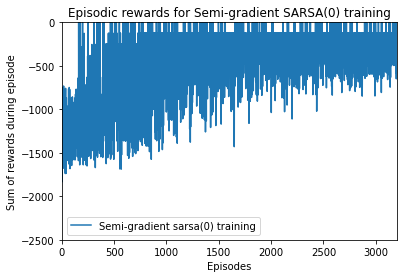

In [23]:
# Present results of episodic semi-gradient sarsa(0) Training
plt.plot(np.arange(NUMBER_OF_TRAINING_EPISODES), training_sg_sarsa_0_episode_rewards[-NUMBER_OF_TRAINING_EPISODES:], label='Semi-gradient sarsa(0) training')
plt.ylim(-2500, 0)
plt.xlim(0, NUMBER_OF_TRAINING_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Episodic rewards for Semi-gradient SARSA(0) training')
plt.legend()

print("")
print("\nEpisodic semi-gradient sarsa(0) Training")
print("Average reward per episode over last 100 episodes:", np.mean(training_sg_sarsa_0_episode_rewards[-100:]))

In [24]:
# Run the trained semi-gradient sarsa(0) estimator model for 100 episodes and exploit only.  Given the problem is stationary, once
# we have trained to convergence, there shouldn't be any need to continue exploration 
sg_sarsa_0_episode_rewards, sg_sarsa_0_weights = semi_gradient_sarsa_0(environment = ENVIRONMENT, 
                                                estimator = sg_sarsa_0_estimator,
                                                gamma = GAMMA,
                                                epsilon_start = 0,
                                                epsilon_end = EPSILON_END,
                                                epsilon_decay = EPSILON_DECAY_RATE,
                                                number_episodes = REPORTING_EPISODES
                                                )




Episodic semi-gradient sarsa(0) Inference
Average reward per episode over last 100 episodes: -255.09010464516558


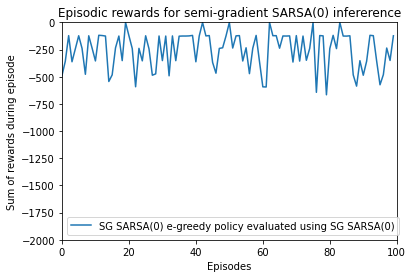

In [25]:
# Present results of semi-gradient sarsa(0) Inference

plt.plot(np.arange(REPORTING_EPISODES), sg_sarsa_0_episode_rewards[-REPORTING_EPISODES:], label='SG SARSA(0) e-greedy policy evaluated using SG SARSA(0)')
plt.ylim(-2000, 0)
plt.xlim(0, REPORTING_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Episodic rewards for semi-gradient SARSA(0) infererence')
plt.legend()

print("")
print("\nEpisodic semi-gradient sarsa(0) Inference")
print("Average reward per episode over last", REPORTING_EPISODES, "episodes:", np.mean(sg_sarsa_0_episode_rewards[-REPORTING_EPISODES:]))

In [26]:
# ANIMATION OF PENDULUM ENVIRONMENT USING POLICY GENERATED BY SARSA(0)

# Remove any existing videos
!rm ./sg_sarsa0_results/*.* 

# Run the environment using the semi-gradient sarsa(0) policy to show animation
# Create the Pendulum-v0 environment
env = gym.make("Pendulum-v0")

# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./sg_sarsa0_results", force=True, video_callable=lambda episode: True)

# Set the display details for the animations
display = Display()
display.start();

# Set the policy to be the policy created implicitly by the sarsa_0_estimator
policy = sg_sarsa_0_estimator

# Run an episode
done = False
state = env.reset()
while not done:
    action = policy.get_greedy_action(state)
    state, reward, done, info = env.step([action])

env.close()

# Show the animation
html = []
for mp4 in Path("./sg_sarsa0_results").glob("*.mp4"):
    video_b64 = base64.b64encode(mp4.read_bytes())
    html.append('''<video alt="{}" autoplay 
                  loop controls style="height: 400px;">
                  <source src="data:video/mp4;base64,{}" type="video/mp4" />
              </video>'''.format(mp4, video_b64.decode('ascii')))

ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

rm: cannot remove './sg_sarsa0_results/*.*': No such file or directory


**EPISODIC SEMI-GRADIENT TD(LAMBDA) RELATED CODE**

In [27]:
class TC_State_Value_Estimator():

    # State value estimator using tile coding for featurisation

    def __init__(self, environment_state_space, number_tilings, number_tiles, step_size, lambda_value):  
        
        self.alpha = step_size / number_tilings     
        self.lambda_value = lambda_value   

        # Tile coding variables
        self.number_tilings = number_tilings
        self.number_tiles = number_tiles
        self.number_state_dimensions = len(environment_state_space.low)
        self.maximum_tiles = (number_tilings + 1)**self.number_state_dimensions * number_tilings        
        self.iht = IHT(self.maximum_tiles)  

        # Calculate scaling values for the state space.  These scales will be used to scale the state value when retrieving active tiles 
        # The scalings are based on the number of tiles divided by the ranges for each element in the state space
        self.state_space_scales = self.number_tilings / (environment_state_space.high - environment_state_space.low)

        # Initialize weights
        self.weights = np.zeros(self.maximum_tiles)

        # Initialise eligibility traces
        self.eligibility_traces = np.zeros(self.maximum_tiles)
    
    def get_maximum_tiles(self):
        return self.maximum_tiles  

    def reset_weights(self):
        self.weights = np.zeros(self.get_maximum_tiles())

    def set_weights(self, weights):
        self.weights = weights

    def reset_eligibility_traces(self):       
        self.eligibility_traces = np.zeros(self.get_maximum_tiles())

    def get_features(self, state):
        # Obtain features (active tiles) for given state 

        # Scale the state by multiplying the state by their relative scales
        scaled_state = np.multiply(self.state_space_scales, state)
        
        # Locate features which are the active tiles
        features = tiles(self.iht,
                             self.number_tilings, 
                             scaled_state)
        
        return np.array(features)

    def update_weights(self, state, target):

        # Retrieve the features for the given state
        features = self.get_features(state)
         
        # Calculate the value estimate as the sum of the weights for the features
        estimated_value = np.sum(self.weights[features])

        # Calculate the td error, the difference between the target and the estimated value
        td_error = (target - estimated_value)

        # Set the replacing trace
        self.eligibility_traces[features] = 1  

        # Update the weights in proportion to the td error, learning rate and trace value
        self.weights[features] += self.alpha * td_error * self.eligibility_traces[features]

    def estimate_value(self, state):
        # Retrieve the features for the given state
        features = self.get_features(state)
         
        # Calculate the value estimate as the sum of the weights for the features
        estimated_value = np.sum(self.weights[features])

        return estimated_value

In [28]:
# Episodic semi-gradient TD(lambda) code
def semi_gradient_td_lambda(environment, estimator, gamma, epsilon_start, epsilon_end, epsilon_decay, number_episodes, policy):

    # Initialisations for the function
    epsilon = epsilon_start
    episode_rewards_history = []

    for episode in range(number_episodes):

        # Reset the environment
        state = environment.reset()

        # Select an action based on the provided policy
        action = policy.get_greedy_action(state) 

        # Initialisations for the episode
        estimator.reset_eligibility_traces()
        episode_rewards = 0
        done = False

        # Loop through each timestep in the episode
        while not done:

            # Take action A and observe R, S'
            next_state, reward, done, _ = environment.step([action])

            if done:
                # If the environment is finished then update the weights using the state and current reward
                estimator.update_weights(state, reward)
            else:
                # Choose next action based on the provided policy
                next_action = policy.get_greedy_action(next_state)        

                # Estimate value at next state
                next_step_estimated_value = estimator.estimate_value(next_state)
                target = reward + gamma * next_step_estimated_value

                # Update the weights using the state and target calculated using the estimated value for the next step
                estimator.update_weights(state, target)

                state = next_state
                action = next_action

                episode_rewards += reward      

        # Decay the epsilon
        epsilon = max(epsilon * epsilon_decay, epsilon_end)

        # Add the episode rewards to the history
        episode_rewards_history.append(episode_rewards)
  
    return episode_rewards_history, estimator.weights

In [29]:
# Create a random policy which determines actions randomly from the given action space
class Random_Policy():
    def __init__(self, action_space):
        self.action_space = action_space

    def get_greedy_action(self, state, epsilon=0):
        action = np.random.choice(self.action_space)
        
        return action

In [30]:
# Run TD lambda code
TD_LAMBDA_VALUE = 0.4
TD_STEP_SIZE = 0.5
TD_EPISODES = 100

# Create an estimator
state_value_estimator = TC_State_Value_Estimator(ENVIRONMENT.observation_space,
                                      NUMBER_TILINGS,
                                      NUMBER_TILES,
                                      TD_STEP_SIZE,
                                      lambda_value= TD_LAMBDA_VALUE)

# Set the policy to be a random policy
policy = Random_Policy(ACTION_SPACE)

# Perform semi-gradient sarsa(0)
random_policy_value, sg_td_lambda_weights = semi_gradient_td_lambda(
                                                environment = ENVIRONMENT, 
                                                estimator = state_value_estimator,
                                                gamma = GAMMA,
                                                epsilon_start = EPSILON_START,
                                                epsilon_end = EPSILON_END,
                                                epsilon_decay = EPSILON_DECAY_RATE,                                               
                                                number_episodes = TD_EPISODES,
                                                policy = policy
                                                )



Episodic semi-gradient TD(lambda) evaluating random policy
Average reward per episode over 100 episodes: -1255.1512784211793



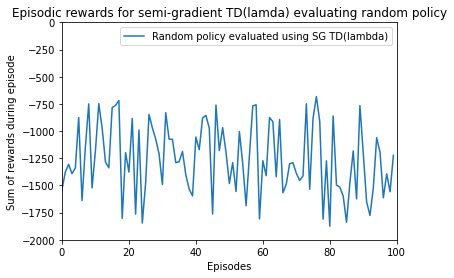

In [31]:
# Present results of episodic semi-gradient TD(lambda) evaluating random policy
print("\nEpisodic semi-gradient TD(lambda) evaluating random policy")
print("Average reward per episode over", TD_EPISODES, "episodes:", np.mean(random_policy_value[-TD_EPISODES:]))

print("")
plt.plot(np.arange(REPORTING_EPISODES), random_policy_value[-REPORTING_EPISODES:], label='Random policy evaluated using SG TD(lambda)')
plt.ylim(-2000, 0)
plt.xlim(0, REPORTING_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Episodic rewards for semi-gradient TD(lamda) evaluating random policy')
plt.legend()

In [32]:
# Create an estimator
state_value_estimator = TC_State_Value_Estimator(ENVIRONMENT.observation_space,
                                      NUMBER_TILINGS,
                                      NUMBER_TILES,
                                      TD_STEP_SIZE,
                                      lambda_value= TD_LAMBDA_VALUE)

# Set the policy to be the policy created implicitly by the sarsa_0_estimator
policy = sg_sarsa_0_estimator

# Perform semi-gradient sarsa(0)
sg_sarsa0_policy_value, sg_td_lambda_weights = semi_gradient_td_lambda(
                                                environment = ENVIRONMENT, 
                                                estimator = state_value_estimator,
                                                gamma = GAMMA,
                                                epsilon_start = EPSILON_START,
                                                epsilon_end = EPSILON_END,
                                                epsilon_decay = EPSILON_DECAY_RATE,                                               
                                                number_episodes = TD_EPISODES,
                                                policy = policy
                                                )



Episodic semi-gradient TD(lambda) evaluating semi-gradient SARSA(0) e-greedy policy
Average reward per episode over 100 episodes: -209.5352485910199



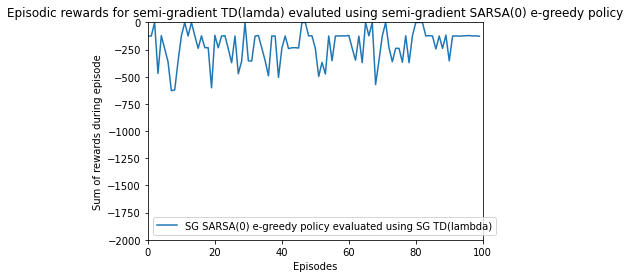

In [33]:
# Present results of episodic semi-gradient TD(lambda) evaluating semi-gradient SARSA(0) e-greedy policy
print("\nEpisodic semi-gradient TD(lambda) evaluating semi-gradient SARSA(0) e-greedy policy")
print("Average reward per episode over", TD_EPISODES, "episodes:", np.mean(sg_sarsa0_policy_value[-TD_EPISODES:]))

print("")
plt.plot(np.arange(TD_EPISODES), sg_sarsa0_policy_value[-TD_EPISODES:], label='SG SARSA(0) e-greedy policy evaluated using SG TD(lambda)')
plt.ylim(-2000, 0)
plt.xlim(0, TD_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Episodic rewards for semi-gradient TD(lamda) evaluted using semi-gradient SARSA(0) e-greedy policy')
plt.legend()

**COMPARISON OF RESULTS**



Random Policy evaluated using Semi-gradient TD(lambda)
Average reward per episode over 100 episodes: -1255.1512784211793

Semi-gradient SARSA(0) e-greedy policy evaulated using Semi-gradient TD(lambda)
Average reward per episode over 100 episodes: -209.5352485910199

Semi-gradient SARSA(0) e-greedy policy evaluated using Semi-gradient SARSA(0)
Average reward per episode over 100 episodes: -255.09010464516558


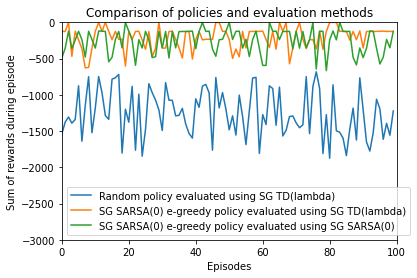

In [36]:
# Compare results of methods and policies

plt.plot(np.arange(REPORTING_EPISODES), random_policy_value[-REPORTING_EPISODES:], label='Random policy evaluated using SG TD(lambda)')
plt.plot(np.arange(REPORTING_EPISODES), sg_sarsa0_policy_value[-REPORTING_EPISODES:], label='SG SARSA(0) e-greedy policy evaluated using SG TD(lambda)')
plt.plot(np.arange(REPORTING_EPISODES), sg_sarsa_0_episode_rewards[-REPORTING_EPISODES:], label='SG SARSA(0) e-greedy policy evaluated using SG SARSA(0)')

plt.ylim(-3000, 0)
plt.xlim(0, REPORTING_EPISODES)
plt.xlabel('Episodes')
plt.ylabel('Sum of rewards during episode')
plt.title('Comparison of policies and evaluation methods')
plt.legend()

print("")
print("\nRandom Policy evaluated using Semi-gradient TD(lambda)")
print("Average reward per episode over", REPORTING_EPISODES, "episodes:", np.mean(random_policy_value[-100:]))

print("\nSemi-gradient SARSA(0) e-greedy policy evaulated using Semi-gradient TD(lambda)")
print("Average reward per episode over", REPORTING_EPISODES, "episodes:", np.mean(sg_sarsa0_policy_value[-100:]))

print("\nSemi-gradient SARSA(0) e-greedy policy evaluated using Semi-gradient SARSA(0)")
print("Average reward per episode over", REPORTING_EPISODES, "episodes:", np.mean(sg_sarsa_0_episode_rewards[-100:]))
